In [1]:
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('SalaryPrediction').getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/10/09 08:59:06 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [97]:
df = spark.read.csv('Datasets/salary1.csv', inferSchema=True, header=True)
df2 = spark.read.csv('Datasets/salary2.csv', inferSchema=True, header=True)
df = df.union(df2)

In [3]:
df.printSchema()
df.count()

root
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: integer (nullable = true)
 |-- education: string (nullable = true)
 |-- education-num: integer (nullable = true)
 |-- marital-status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital-gain: integer (nullable = true)
 |-- capital-loss: integer (nullable = true)
 |-- hours-per-week: integer (nullable = true)
 |-- native-country: string (nullable = true)
 |-- income: string (nullable = true)



48842

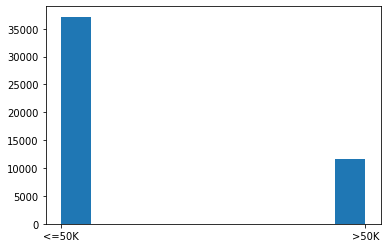

<=50K: 37155
>50K: 11687


In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
incomeArr = np.array(df.select('income').collect())
plt.hist(incomeArr)
plt.show()
print("<=50K: "+str(df.filter(df['income'] == '<=50K').count()))
print(">50K: "+str(df.filter(df['income'] == '>50K').count()))

In [5]:
from pyspark.sql.functions import col,isnan, when, count
df.select('age').orderBy('age', ascending=False).show(1)
df.select('age').orderBy('age').show(1)
ageWithIncome = df.select("*",when(df['age'] <=20, '0-20')
          .when((df['age'] >20) & (df['age'] <= 40), '21-40')
          .when((df['age'] >40) & (df['age'] <= 60), '41-60')
          .when((df['age'] >60) & (df['age'] <= 80), '61-80')
          .otherwise('80+').alias('age_range')).groupBy("income","age_range").count().orderBy('age_range','income').show()

+---+
|age|
+---+
| 90|
+---+
only showing top 1 row

+---+
|age|
+---+
| 17|
+---+
only showing top 1 row



+------+---------+-----+
|income|age_range|count|
+------+---------+-----+
| <=50K|     0-20| 3619|
|  >50K|     0-20|    4|
| <=50K|    21-40|20411|
|  >50K|    21-40| 4597|
| <=50K|    41-60|10370|
|  >50K|    41-60| 6235|
| <=50K|    61-80| 2632|
|  >50K|    61-80|  826|
| <=50K|      80+|  123|
|  >50K|      80+|   25|
+------+---------+-----+



In [6]:
df.groupBy("income","education-num").count().orderBy('education-num','income', ascending=False).show(40)


+------+-------------+-----+
|income|education-num|count|
+------+-------------+-----+
|  >50K|           16|  431|
| <=50K|           16|  163|
|  >50K|           15|  617|
| <=50K|           15|  217|
|  >50K|           14| 1459|
| <=50K|           14| 1198|
|  >50K|           13| 3313|
| <=50K|           13| 4712|
|  >50K|           12|  413|
| <=50K|           12| 1188|
|  >50K|           11|  522|
| <=50K|           11| 1539|
|  >50K|           10| 2063|
| <=50K|           10| 8815|
|  >50K|            9| 2503|
| <=50K|            9|13281|
|  >50K|            8|   48|
| <=50K|            8|  609|
|  >50K|            7|   92|
| <=50K|            7| 1720|
|  >50K|            6|   87|
| <=50K|            6| 1302|
|  >50K|            5|   41|
| <=50K|            5|  715|
|  >50K|            4|   62|
| <=50K|            4|  893|
|  >50K|            3|   27|
| <=50K|            3|  482|
|  >50K|            2|    8|
| <=50K|            2|  239|
|  >50K|            1|    1|
| <=50K|      

In [7]:
df.select('hours-per-week').orderBy('hours-per-week', ascending=False).show(1)
df.select('hours-per-week').orderBy('hours-per-week').show(1)
hoursWithIncome = df.select("*",when(df['hours-per-week'] <=20, '0-20')
          .when((df['hours-per-week'] >20) & (df['hours-per-week'] <= 40), '21-40')
          .when((df['hours-per-week'] >40) & (df['hours-per-week'] <= 60), '41-60')
          .when((df['hours-per-week'] >60) & (df['hours-per-week'] <= 80), '61-80')
          .otherwise('80+').alias('hours_range')).groupBy("income","hours_range").count().orderBy('hours_range','income').show()


+--------------+
|hours-per-week|
+--------------+
|            99|
+--------------+
only showing top 1 row

+--------------+
|hours-per-week|
+--------------+
|             1|
+--------------+
only showing top 1 row

+------+-----------+-----+
|income|hours_range|count|
+------+-----------+-----+
| <=50K|       0-20| 4152|
|  >50K|       0-20|  301|
| <=50K|      21-40|24393|
|  >50K|      21-40| 5644|
| <=50K|      41-60| 7533|
|  >50K|      41-60| 5143|
| <=50K|      61-80|  859|
|  >50K|      61-80|  499|
| <=50K|        80+|  218|
|  >50K|        80+|  100|
+------+-----------+-----+



In [8]:
non_string_cols = [c for c, t in df.dtypes if t !='string']
bounds = {
    c: dict(
        zip(["q1", "q3"], df.approxQuantile(c, [0.25, 0.75], 0))
    )
    # numeric columns
    for c in non_string_cols
}

for c in bounds:
    iqr = bounds[c]['q3'] - bounds[c]['q1']
    bounds[c]['lower'] = bounds[c]['q1'] - (iqr * 1.5)
    bounds[c]['upper'] = bounds[c]['q3'] + (iqr * 1.5)
outliers=df.select(
    "*",
    *[
        when(
            col(c).between(bounds[c]['lower'], bounds[c]['upper']),
            0
        ).otherwise(1).alias(c+"_out") 
        for c in non_string_cols
    ]
).select('age_out','fnlwgt_out','education-num_out','capital-gain_out','capital-loss_out','hours-per-week_out')
outliers.groupBy().sum().collect()

[Row(sum(age_out)=216, sum(fnlwgt_out)=1453, sum(education-num_out)=1794, sum(capital-gain_out)=4035, sum(capital-loss_out)=2282, sum(hours-per-week_out)=13496)]

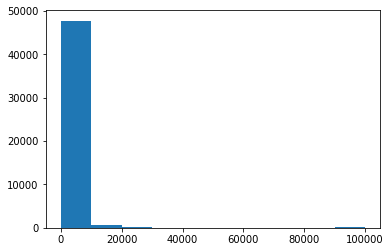

In [9]:
incomeArr = np.array(df.select('capital-gain').collect())
plt.hist(incomeArr)
plt.show()

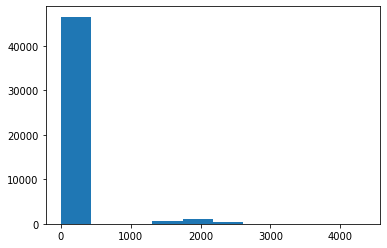

In [10]:
incomeArr = np.array(df.select('capital-loss').collect())
plt.hist(incomeArr)
plt.show()

In [11]:
df = df.drop('fnlwgt', 'education', 'capital-gain', 'capital-loss')
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- education-num: integer (nullable = true)
 |-- marital-status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- hours-per-week: integer (nullable = true)
 |-- native-country: string (nullable = true)
 |-- income: string (nullable = true)



In [12]:
for c in df.columns:
    print(c + ": " + str(df.filter(col(c).contains('?')).count()))


age: 0
workclass: 2799
education-num: 0
marital-status: 0
occupation: 2809
relationship: 0
race: 0
sex: 0
hours-per-week: 0
native-country: 857
income: 0


In [13]:
df = df.filter((df['workclass'] != '?') & (df['occupation'] != '?') & (df['native-country'] != '?'))
df.count()

45222

In [14]:
for c in df.columns:
    print(c + ": " + str(df.filter(col(c) == '?').count()))

age: 0
workclass: 0
education-num: 0
marital-status: 0
occupation: 0
relationship: 0
race: 0
sex: 0
hours-per-week: 0
native-country: 0
income: 0


In [15]:
non_string_cols = [c for c, t in df.dtypes if t !='string']
bounds = {
    c: dict(
        zip(["q1", "q3"], df.approxQuantile(c, [0.25, 0.75], 0))
    )
    # numeric columns
    for c in non_string_cols
}

for c in bounds:
    iqr = bounds[c]['q3'] - bounds[c]['q1']
    bounds[c]['lower'] = bounds[c]['q1'] - (iqr * 1.5)
    bounds[c]['upper'] = bounds[c]['q3'] + (iqr * 1.5)
outliers=df.select(
    "*",
    *[
        when(
            col(c).between(bounds[c]['lower'], bounds[c]['upper']),
            0
        ).otherwise(1).alias(c+"_out") 
        for c in non_string_cols
    ]
).select('age_out','education-num_out','hours-per-week_out')
outliers.groupBy().sum().collect()

[Row(sum(age_out)=269, sum(education-num_out)=294, sum(hours-per-week_out)=11899)]

In [16]:
df.select('education-num').distinct().count()

16

In [17]:
df = df.select("*",when((df['education-num']>0) & (df['education-num']<=9),1)
              .when((df['education-num']>9) & (df['education-num']<=12),2)
              .when(df['education-num']==13,3)
              .otherwise(4).alias("education")
    )
df.groupBy("education").count().orderBy('education').show()


+---------+-----+
|education|count|
+---------+-----+
|        1|20444|
|        2|13365|
|        3| 7570|
|        4| 3843|
+---------+-----+



In [18]:
df = df.select("*",when(df['native-country'] == 'United-States',1)
              .otherwise(2).alias("native-country-processed")
    )
df.groupBy("native-country-processed").count().orderBy('native-country-processed').show()

+------------------------+-----+
|native-country-processed|count|
+------------------------+-----+
|                       1|41292|
|                       2| 3930|
+------------------------+-----+



In [19]:
df = df.select("*",when(df['race'] == 'White',1)
              .otherwise(2).alias("race-processed")
    )
df.groupBy("race-processed").count().orderBy('race-processed').show()

+--------------+-----+
|race-processed|count|
+--------------+-----+
|             1|38903|
|             2| 6319|
+--------------+-----+



In [20]:
df = df.select("*",when(df['workclass'] == 'Private',1)
              .when((df['workclass'] == 'Local-gov') | (df['workclass'] == 'State-gov') | (df['workclass'] == 'Federal-gov'),2)
              .when((df['workclass'] == 'Self-emp-not-inc') | (df['workclass'] == 'Self-emp-inc'),3)
              .otherwise(4).alias("workclass-processed")
    )
df.groupBy("workclass-processed").count().orderBy('workclass-processed').show()

+-------------------+-----+
|workclass-processed|count|
+-------------------+-----+
|                  1|33307|
|                  2| 6452|
|                  3| 5442|
|                  4|   21|
+-------------------+-----+



In [21]:
df = df.select("*",when((df['age']>=17) & (df['age']<=39),1)
              .when((df['age']>39) & (df['age']<=60),2)
              .otherwise(3).alias("age-processed")
    )
df.groupBy("age-processed").count().orderBy('age-processed').show()

+-------------+-----+
|age-processed|count|
+-------------+-----+
|            1|25407|
|            2|16967|
|            3| 2848|
+-------------+-----+



In [22]:
df = df.select("*",when(df['hours-per-week']<20,1)
              .when((df['hours-per-week']>=20) & (df['hours-per-week']<=40),2)
              .otherwise(3).alias("hours-per-week-processed")
    )
df.groupBy("hours-per-week-processed").count().orderBy('hours-per-week-processed').show()

+------------------------+-----+
|hours-per-week-processed|count|
+------------------------+-----+
|                       1| 2000|
|                       2|29445|
|                       3|13777|
+------------------------+-----+



In [23]:
from pyspark.ml.feature import (VectorAssembler,VectorIndexer,
                                StringIndexer)
from pyspark.ml import Pipeline

maritalStatus_indexer = StringIndexer(inputCol='marital-status',outputCol='maritalStatusIndex')
occupation_indexer = StringIndexer(inputCol='occupation',outputCol='occupationIndex')
relationship_indexer = StringIndexer(inputCol='relationship',outputCol='relationshipIndex')
gender_indexer = StringIndexer(inputCol='sex',outputCol='sexIndex')
income_indexer = StringIndexer(inputCol='income',outputCol='incomeIndex')

transformPipeline = Pipeline(stages=[maritalStatus_indexer,occupation_indexer, relationship_indexer, gender_indexer,
                           income_indexer])

fit_model = transformPipeline.fit(df)
df = fit_model.transform(df)

In [24]:
df = df.drop('age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex',
            'hours-per-week', 'native-country', 'income')
df.printSchema()

root
 |-- education: integer (nullable = false)
 |-- native-country-processed: integer (nullable = false)
 |-- race-processed: integer (nullable = false)
 |-- workclass-processed: integer (nullable = false)
 |-- age-processed: integer (nullable = false)
 |-- hours-per-week-processed: integer (nullable = false)
 |-- maritalStatusIndex: double (nullable = false)
 |-- occupationIndex: double (nullable = false)
 |-- relationshipIndex: double (nullable = false)
 |-- sexIndex: double (nullable = false)
 |-- incomeIndex: double (nullable = false)



In [25]:
featureColumns = ['native-country-processed','education', 'maritalStatusIndex', 'occupationIndex', 'relationshipIndex', 'sexIndex', 'race-processed', 'workclass-processed','age-processed','hours-per-week-processed']
assembler = VectorAssembler(inputCols=featureColumns,outputCol='features')
df = assembler.transform(df)
df.select('features', 'incomeIndex').show()

+--------------------+-----------+
|            features|incomeIndex|
+--------------------+-----------+
|[1.0,3.0,1.0,3.0,...|        0.0|
|[1.0,3.0,0.0,2.0,...|        0.0|
|[1.0,1.0,2.0,8.0,...|        0.0|
|[1.0,1.0,0.0,8.0,...|        0.0|
|[2.0,3.0,0.0,1.0,...|        0.0|
|[1.0,4.0,0.0,2.0,...|        0.0|
|[2.0,1.0,5.0,5.0,...|        0.0|
|[1.0,1.0,0.0,2.0,...|        1.0|
|[1.0,4.0,1.0,1.0,...|        1.0|
|[1.0,3.0,0.0,2.0,...|        1.0|
|[1.0,2.0,0.0,2.0,...|        1.0|
|[2.0,3.0,0.0,1.0,...|        1.0|
|[1.0,3.0,1.0,3.0,...|        0.0|
|[1.0,2.0,1.0,4.0,...|        0.0|
|[2.0,1.0,0.0,7.0,...|        0.0|
|[1.0,1.0,1.0,9.0,...|        0.0|
|[1.0,1.0,1.0,6.0,...|        0.0|
|[1.0,1.0,0.0,4.0,...|        0.0|
|[1.0,4.0,2.0,2.0,...|        1.0|
|[1.0,4.0,0.0,1.0,...|        1.0|
+--------------------+-----------+
only showing top 20 rows



In [26]:
from pyspark.ml.feature import ChiSqSelector
selector = ChiSqSelector(numTopFeatures=9, featuresCol="features",
                         outputCol="selectedFeatures", labelCol="incomeIndex")

model = selector.fit(df)

#numTopFeatures = n-1, so unselected column is the least important one
np.array(featureColumns)[model.selectedFeatures]

array(['education', 'maritalStatusIndex', 'occupationIndex',
       'relationshipIndex', 'sexIndex', 'race-processed',
       'workclass-processed', 'age-processed', 'hours-per-week-processed'],
      dtype='<U24')

In [27]:
#drop the features column because I will re-create it without native country
df = df.drop('features')
featureColumns = ['education', 'maritalStatusIndex', 'occupationIndex', 'relationshipIndex', 'sexIndex', 'race-processed', 'workclass-processed','age-processed','hours-per-week-processed']
assembler = VectorAssembler(inputCols=featureColumns,outputCol='features')
df = assembler.transform(df)
df = df.drop('native-country-processed')

In [28]:
from pyspark.ml.stat import Correlation
corrTest = df.select('features');

matrix = Correlation.corr(corrTest, 'features')
matrix.collect()[0]["pearson({})".format('features')].values

22/10/09 08:59:57 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/10/09 08:59:57 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


array([ 1.        , -0.09686754, -0.25461382, -0.10905198, -0.0131121 ,
       -0.04655673,  0.1392943 ,  0.05542594,  0.16569144, -0.09686754,
        1.        ,  0.05193543,  0.42184271,  0.41071485,  0.09970559,
       -0.08495405,  0.04756525, -0.14218319, -0.25461382,  0.05193543,
        1.        ,  0.06434085, -0.00176278,  0.05866081, -0.05289131,
       -0.04113838, -0.0753535 , -0.10905198,  0.42184271,  0.06434085,
        1.        ,  0.55605286,  0.14746137, -0.11952762, -0.16781898,
       -0.22464532, -0.0131121 ,  0.41071485, -0.00176278,  0.55605286,
        1.        ,  0.10330815, -0.10607579, -0.04846522, -0.21729992,
       -0.04655673,  0.09970559,  0.05866081,  0.14746137,  0.10330815,
        1.        , -0.03858471, -0.02795702, -0.08994482,  0.1392943 ,
       -0.08495405, -0.05289131, -0.11952762, -0.10607579, -0.03858471,
        1.        ,  0.19888972,  0.11471942,  0.05542594,  0.04756525,
       -0.04113838, -0.16781898, -0.04846522, -0.02795702,  0.19

In [31]:
train_set, test_set = df.randomSplit([0.7,.3])
print(train_set)

root
 |-- education: integer (nullable = false)
 |-- race-processed: integer (nullable = false)
 |-- workclass-processed: integer (nullable = false)
 |-- age-processed: integer (nullable = false)
 |-- hours-per-week-processed: integer (nullable = false)
 |-- maritalStatusIndex: double (nullable = false)
 |-- occupationIndex: double (nullable = false)
 |-- relationshipIndex: double (nullable = false)
 |-- sexIndex: double (nullable = false)
 |-- incomeIndex: double (nullable = false)
 |-- features: vector (nullable = true)



In [47]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics

logistic_reg = LogisticRegression(featuresCol='features',labelCol='incomeIndex')

logistic_paramGrid = (ParamGridBuilder()
             .addGrid(logistic_reg.regParam, [0.01, 0.1, 0.5, 1.0, 2.0])
             .addGrid(logistic_reg.elasticNetParam, [0.0, 0.25, 0.5, 0.75, 1.0])
             .addGrid(logistic_reg.maxIter, [1, 5, 10, 20, 50])
             .build())

logistic_evaluator = BinaryClassificationEvaluator(labelCol='incomeIndex')

logistic_CrossValidator = CrossValidator(estimator = logistic_reg,
                    estimatorParamMaps = logistic_paramGrid,
                    evaluator = logistic_evaluator,
                    numFolds = 5)

logistic_Model = logistic_CrossValidator.fit(train_set)

logistic_predictions = logistic_Model.transform(test_set)

print('Accuracy:', logistic_evaluator.evaluate(logistic_predictions))
print('AUC:', BinaryClassificationMetrics(logistic_predictions['incomeIndex','prediction'].rdd).areaUnderROC)

Accuracy: 0.8428387179681875
AUC: 0.7657430966538744


In [36]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol="incomeIndex", featuresCol="features")

rf_paramGrid = (ParamGridBuilder()
             .addGrid(rf.numTrees, [10, 20, 30])
             .addGrid(rf.featureSubsetStrategy, [ "auto", "all", "sqrt", "log2", "onethird"])
             .addGrid(rf.maxDepth, [3, 4, 5])
             .build())

rf_evaluator = BinaryClassificationEvaluator(labelCol='incomeIndex')

rf_CrossValidator = CrossValidator(estimator = rf,
                    estimatorParamMaps = rf_paramGrid,
                    evaluator = rf_evaluator,
                    numFolds = 5)

rf_Model = rf_CrossValidator.fit(train_set)

rf_predictions = rf_Model.transform(test_set)

print('Accuracy:', rf_evaluator.evaluate(rf_predictions))
print('AUC:', BinaryClassificationMetrics(rf_predictions['incomeIndex','prediction'].rdd).areaUnderROC)

Accuracy: 0.8687885155697823


AUC: 0.7825563034461543


In [39]:
best_lrmodel = logistic_Model.bestModel
best_lrmodel.coefficients
#'education', 'maritalStatusIndex', 'occupationIndex', 'relationshipIndex', 'sexIndex', 'race-processed', 'workclass-processed','age-processed','hours-per-week-processed'

DenseVector([0.6625, -0.8418, -0.0456, -0.0371, -0.2724, -0.0562, 0.0, 0.5891, 0.6593])

In [86]:
best_rfmodel = rf_Model.bestModel
best_rfmodel.featureImportances

SparseVector(9, {0: 0.2656, 1: 0.3932, 2: 0.0885, 3: 0.1972, 4: 0.0132, 5: 0.0002, 6: 0.0009, 7: 0.0249, 8: 0.0163})

In [58]:
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import FloatType

rf_datacast = rf_predictions.select(['prediction','incomeIndex']).withColumn('incomeIndex', col('incomeIndex').cast(FloatType())).orderBy('prediction')

rf_datacast = lr_datacast.select(['prediction','incomeIndex'])

rf_metrics = MulticlassMetrics(rf_datacast.rdd.map(tuple))

print(rf_metrics.confusionMatrix().toArray())

[[9568.  562.]
 [2028. 1352.]]


In [71]:
print("RegParam: " + str(best_lrmodel.getRegParam()))
print("ElasticNetParam: " + str(best_lrmodel.getElasticNetParam()))
print("MaxIter: " + str(best_lrmodel.getMaxIter()))

RegParam: 0.01
ElasticNetParam: 0.75
MaxIter: 10


In [80]:
logistic_predictions.select('rawPrediction', 'probability', 'prediction').show(5,truncate=False)

+----------------------------------------+-----------------------------------------+----------+
|rawPrediction                           |probability                              |prediction|
+----------------------------------------+-----------------------------------------+----------+
|[2.852506768220406,-2.852506768220406]  |[0.9454481162631222,0.054551883736877804]|0.0       |
|[3.1196182481125683,-3.1196182481125683]|[0.9576947639903971,0.0423052360096029]  |0.0       |
|[3.1196182481125683,-3.1196182481125683]|[0.9576947639903971,0.0423052360096029]  |0.0       |
|[3.1196182481125683,-3.1196182481125683]|[0.9576947639903971,0.0423052360096029]  |0.0       |
|[3.1196182481125683,-3.1196182481125683]|[0.9576947639903971,0.0423052360096029]  |0.0       |
+----------------------------------------+-----------------------------------------+----------+
only showing top 5 rows



In [90]:
print("NumTrees: " + str(best_rfmodel.getOrDefault('numTrees')))
print("FeatureSubsetStrategy: " + str(best_rfmodel.getFeatureSubsetStrategy()))
print("MaxDepth: " + str(best_rfmodel.getMaxDepth()))

NumTrees: 30
FeatureSubsetStrategy: log2
MaxDepth: 5


In [91]:
rf_predictions.select('rawPrediction', 'probability', 'prediction').show(5,truncate=False)

+---------------------------------------+-----------------------------------------+----------+
|rawPrediction                          |probability                              |prediction|
+---------------------------------------+-----------------------------------------+----------+
|[23.021969014587256,6.978030985412741] |[0.7673989671529087,0.2326010328470914]  |0.0       |
|[28.825964144738425,1.1740358552615793]|[0.9608654714912808,0.039134528508719305]|0.0       |
|[28.825964144738425,1.1740358552615793]|[0.9608654714912808,0.039134528508719305]|0.0       |
|[28.825964144738425,1.1740358552615793]|[0.9608654714912808,0.039134528508719305]|0.0       |
|[28.825964144738425,1.1740358552615793]|[0.9608654714912808,0.039134528508719305]|0.0       |
+---------------------------------------+-----------------------------------------+----------+
only showing top 5 rows



In [92]:
train_set1, test_set1 = df.randomSplit([0.8,.2])

logistic_Model = logistic_CrossValidator.fit(train_set1)

logistic_predictions = logistic_Model.transform(test_set1)

print('Accuracy:', logistic_evaluator.evaluate(logistic_predictions))
print('AUC:', BinaryClassificationMetrics(logistic_predictions['incomeIndex','prediction'].rdd).areaUnderROC)

Accuracy: 0.8350546595722678


AUC: 0.7571480003769026


In [93]:
rf_Model = rf_CrossValidator.fit(train_set1)

rf_predictions = rf_Model.transform(test_set1)

print('Accuracy:', rf_evaluator.evaluate(rf_predictions))
print('AUC:', BinaryClassificationMetrics(rf_predictions['incomeIndex','prediction'].rdd).areaUnderROC)

Accuracy: 0.8659977266005154
AUC: 0.7809009952854897


In [96]:
rf = RandomForestClassifier(labelCol="incomeIndex", featuresCol="features", bootstrap=False)

rf_paramGrid = (ParamGridBuilder()
             .addGrid(rf.numTrees, [10, 20, 30])
             .addGrid(rf.featureSubsetStrategy, [ "auto", "all", "sqrt", "log2", "onethird"])
             .addGrid(rf.maxDepth, [3, 4, 5])
             .build())

rf_evaluator = BinaryClassificationEvaluator(labelCol='incomeIndex')

rf_CrossValidator = CrossValidator(estimator = rf,
                    estimatorParamMaps = rf_paramGrid,
                    evaluator = rf_evaluator,
                    numFolds = 5)

rf_Model = rf_CrossValidator.fit(train_set)

rf_predictions = rf_Model.transform(test_set)

print('Accuracy:', rf_evaluator.evaluate(rf_predictions))
print('AUC:', BinaryClassificationMetrics(rf_predictions['incomeIndex','prediction'].rdd).areaUnderROC)

Accuracy: 0.8688258263871448
AUC: 0.7833562721166157
